In [ ]:
import json
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from string import punctuation
from nltk.stem import PorterStemmer
import re
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import multiprocessing
from gensim.models import Word2Vec

In [2]:
# Importamos el archivo sobre el que vamos a trabajar.
# Leemos línea por línea y convertimos cada una en un diccionario de Python usando json.loads()
# Almacenamos cada uno de estos diccionarios en un nuevo diccionario llamado 'data', usando como clave el índice de línea (idx)

data = {}
with open('C:/Users/noeli/Desktop/Practica_NLP/Video_Games_5.json/Video_Games_5.json', "r", encoding="utf-8") as f:
    for idx, line in enumerate(f):
        data[idx] = json.loads(line)

In [3]:
# Extraemos solo los textos de las reseñas ('reviewText') de cada entrada del diccionario 'data' y los almacenamos en una lista llamada 'reviews'

reviews = []

for x in range(len(data)):
  reviews.append(data[x].get('reviewText'))

In [4]:
# Extraemos texto y sentimiento de las reseñas del diccionario 'data' y creamos un DataFrame
# Eliminamos filas con valores faltantes en 'review' o 'sentiment' y reiniciamos el índice

reviews_text = []
reviews_sentiment = []

for review in data.values():
    reviews_text.append(review.get('reviewText'))
    reviews_sentiment.append(review.get('overall'))

df_reviews = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df_reviews.dropna(subset=['review', 'sentiment'], inplace=True)
df_reviews.reset_index(drop=True, inplace=True)

In [5]:
# Preprocesamiento del texto para análisis NLP:
#  Descargamos las stopwords en inglés y definimos el conjunto de palabras a ignorar
#  Creamos un traductor para eliminar puntuación, e inicializamos el stemmer de Porter
#  Para cada reseña del DataFrame:
#    - Convertimos a minúsculas
#    - Eliminamos puntuación y números
#    - Tokenizamos dividiendo por espacios
#    - Aplicamos stemming y eliminamos stopwords
#  Almacenamos todos los tokens procesados y construimos un vocabulario único
#  Finalmente, mostramos el tamaño del vocabulario y las 20 palabras más frecuentes


nltk.download('stopwords', quiet=True)
stop = set(stopwords.words('english'))

translator = str.maketrans('', '', string.punctuation)
stemmer = PorterStemmer()

tokens = []
for text in df_reviews['review']:
    if not text:
        continue

    lower = text.lower() 

    no_punct = lower.translate(translator) 

    clean = re.sub(r'\d+', '', no_punct) 

    words = clean.split() 

    filtered = [stemmer.stem(w) for w in words if w and w not in stop] 

    tokens.extend(filtered)

vocab = set(tokens)
print("Tamaño del vocabulario:", len(vocab))


freq = Counter(tokens)
print("\n20 palabras más comunes:")
for palabra, cuenta in freq.most_common(20):
    print(f"  {palabra}: {cuenta}")

Tamaño del vocabulario: 268296

20 palabras más comunes:
  game: 1277845
  play: 392685
  like: 314690
  get: 270360
  one: 268178
  time: 206717
  great: 196461
  good: 189579
  use: 170254
  realli: 160895
  fun: 156466
  make: 141313
  control: 134633
  much: 132261
  also: 125040
  even: 123415
  dont: 122995
  go: 122386
  would: 121374
  charact: 121048


Distribución de reseñas por estrellas:
sentiment
1.0     30879
2.0     24133
3.0     49140
4.0     93644
5.0    299623
Name: count, dtype: int64


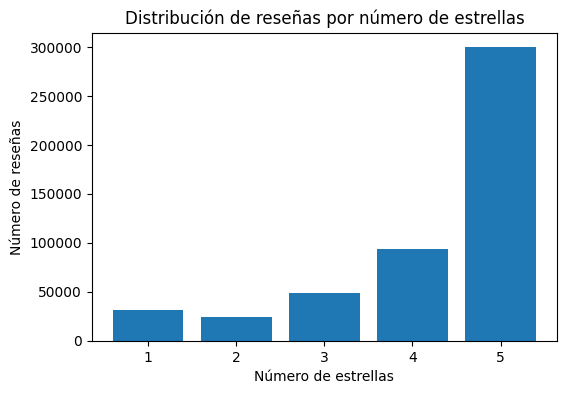

In [6]:
# Calculamos y visualizamos la distribución de reseñas según el número de estrellas ('sentiment')
# Contamos cuántas reseñas hay por cada puntuación, ordenamos los valores, y los representamos en un gráfico de barras que muestra que la mayoría de las reseñas son positivas (con 5 estrellas)

import pandas as pd
import matplotlib.pyplot as plt

counts = df_reviews['sentiment'].value_counts().sort_index()

print("Distribución de reseñas por estrellas:")
print(counts)

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(int), counts.values)
plt.xlabel('Número de estrellas')
plt.ylabel('Número de reseñas')
plt.title('Distribución de reseñas por número de estrellas')
plt.show()

In [7]:
# Función para clasificar una reseña como negativa o positiva según su puntuación ('sentiment')
# Si la puntuación es menor que 3, se considera negativa (devuelve 1)
# En caso contrario (3 o más), se considera positiva (devuelve 0)


def label_sentiment(row): 
    if int(row['sentiment']) < 3:
        return 1 # NEGATIVA
    else:
        return 0 # POSITIVA

In [8]:
# Creamos una copia del DataFrame para evitar posibles efectos secundarios
# Luego, aplicamos la función 'label_sentiment' a cada fila del DataFrame usando apply(), generando una nueva columna 'sentiment_label' con la etiqueta binaria:
# 1 para reseñas negativas y 0 para positivas.

df_reviews = df_reviews.copy() 
df_reviews['sentiment_label'] = df_reviews.apply(lambda row: label_sentiment(row), axis=1) 

Distribución:
Positivas: 442407
Negativas: 55012


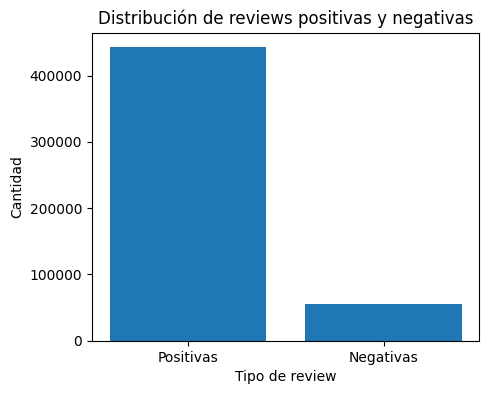

In [9]:
# Calculamos la distribución de reseñas positivas y negativas contando los valores en 'sentiment_label'
# Vemos el número de reseñas para cada categoría y luegolo visualizamos con un gráfico de barras


counts = df_reviews['sentiment_label'].value_counts().sort_index()


print("Distribución:")
print(f"Positivas: {counts[0]}")
print(f"Negativas: {counts[1]}")


plt.figure(figsize=(5,4))
plt.bar(['Positivas', 'Negativas'], counts.values)
plt.xlabel('Tipo de review')
plt.ylabel('Cantidad')
plt.title('Distribución de reviews positivas y negativas')
plt.show()

In [10]:
# Generamos n-gramas a partir de los tokens preprocesados:
# - Bigrams: pares consecutivos de palabras
# - Trigrams: grupos de tres palabras consecutivas
# Calculamos la frecuencia de cada bigrama y trigram usando FreqDist, para identificar las combinaciones de palabras más comunes en el corpus


bigrams = ngrams(tokens, 2)
trigrams = ngrams(tokens, 3)

bigramsfreq = FreqDist(bigrams)
trigramsfreq = FreqDist(trigrams)

In [11]:
# Obtenemos y mostramos los 10 bigramas más frecuentes en el corpus

bigramsfreq.most_common(10)

[(('play', 'game'), 48444),
 (('game', 'play'), 39065),
 (('great', 'game'), 32541),
 (('game', 'like'), 23352),
 (('feel', 'like'), 22280),
 (('video', 'game'), 20442),
 (('good', 'game'), 19667),
 (('love', 'game'), 18720),
 (('fun', 'game'), 17887),
 (('game', 'great'), 16233)]

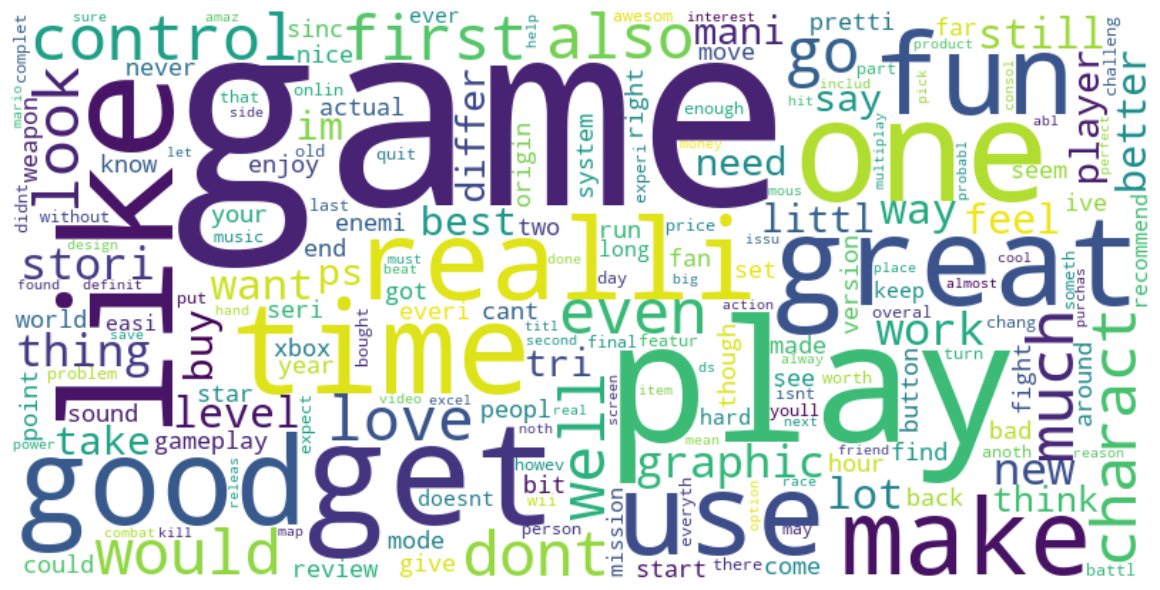

In [ ]:
# Creamos una nube de palabras (WordCloud) a partir de la frecuencia de tokens preprocesados
# Visualizamos gráficamente las palabras más comunes

freq = Counter(tokens)
wc = WordCloud(width=800, height=400, background_color='white') \
         .generate_from_frequencies(freq)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Definimos una función para limpiar el texto de las reseñas:
# Convertimos a minúsculas
# Eliminamos la puntuación
# Quitamos números
# Tokenizamos el texto en palabras
# Eliminamos las stopwords en inglés
# Unimos las palabras limpias en una cadena y devolvemos el texto procesado
# Aplicamos esta función a todas las reseñas no vacías del DataFrame y guardamos el resultado en una lista

stop = set(stopwords.words('english'))
translator_ = str.maketrans('', '', punctuation)

def clean_review(text):
    text = text.lower()
    text = text.translate(translator_)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stop]
    return ' '.join(words)


cleaned_reviews = [clean_review(review) for review in df_reviews["review"] if review]

In [22]:
# Preparación y entrenamiento de un modelo Word2Vec para generar embeddings de palabras:
# Convertimos las reseñas limpias en listas de tokens
# Detectamos el número de núcleos del CPU para paralelizar el entrenamiento
# Inicializamos el modelo Word2Vec con parámetros específicos:
#    - min_count=5: ignorar palabras que aparecen menos de 5 veces
#    - window=2: contexto de dos palabras a cada lado
#    - vector_size=100: tamaño de los vectores de palabra
# Construimos el vocabulario a partir de las frases tokenizadas
# Entrenamos el modelo durante 30 épocas, reportando el tiempo invertido


from time import time

sentences = [row.split() for row in cleaned_reviews]

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=5,
                     window=2,
                     vector_size=100,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)


t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))


t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Tiempo para entrenar el modelo: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para construir el vocabulario: 0.07 mins
Tiempo para entrenar el modelo: 4.76 mins


In [23]:
# Guardamos el modelo Word2Vec entrenado en un archivo local ('w2v_model.pkl')

w2v_model.save('./w2v_model.pkl')

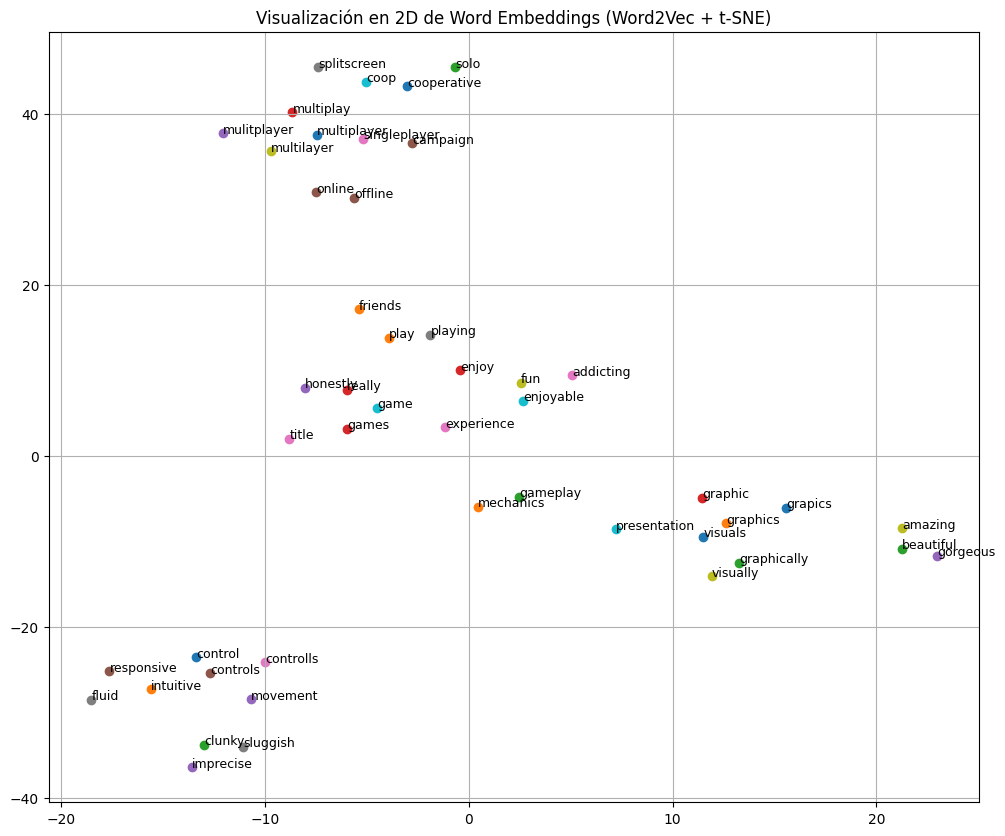

In [26]:
# Visualización de los embeddings de palabras en 2D usando t-SNE:
# Seleccionamos un conjunto de palabras objetivo 
# Filtramos para quedarnos solo con palabras presentes en el vocabulario del modelo
# Obtenemos los vectores de embedding correspondientes y los convertimos a un array NumPy
# Aplicamos t-SNE para reducir la dimensionalidad de los vectores de 100 dimensiones a 2
# Dibujamos un scatter plot con las palabras, posicionándolas según sus vectores y etiquetamos cada punto con la palabra correspondiente
# En el gráfico vemos que las palabras relacionadas con multiplayer están en la izquierda, las relacionadas con game en el centro junto con las de play,
# las relacionadas con graphics en la derecha y las relacionadas con controls abajo en el centro


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

palabras_objetivo = ['game', 'controls', 'graphics', 'multiplayer', 'play']

palabras_visualizar = set(palabras_objetivo)

for palabra in palabras_objetivo:
    if palabra in w2v_model.wv:
        similares = w2v_model.wv.most_similar(palabra, topn=10)
        palabras_visualizar.update([w for w, _ in similares])

palabras_visualizar = [word for word in palabras_visualizar if word in w2v_model.wv]

vectores = [w2v_model.wv[word] for word in palabras_visualizar]
vectores_np = np.array(vectores)  # <- aquí la corrección

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectores_2d = tsne.fit_transform(vectores_np)

plt.figure(figsize=(12, 10))
for i, palabra in enumerate(palabras_visualizar):
    x, y = vectores_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, palabra, fontsize=9)

plt.title("Visualización en 2D de Word Embeddings (Word2Vec + t-SNE)")
plt.grid(True)
plt.show()


In [ ]:
###CONCLUSIONES

## VOCABULARIO
# En cuanto al vocabulario podemos decir que contiene 268.296 palabras únicas con lo cual la riqueza del corpus es bastante elevada, el problema de ello es que puede incluir palavras mal escritas,
# jergas o incluso contracciones.

## FRECUENCIA LÉXICA Y CONTENIDO PREDOMINANTE
# Los términos que más se repiten son "game", "play", "like", "great", "fun", "control", "character"... lo que da a entender que el corpus está fuertemente centrado en la experiencia del jugador
# tanto haciendo referencia al ámbito funcional como al emocional del propio jugador. Predominan opiniones y sensaciones personales, siempre desde un punto de vista subjetivo.

## RESEÑAS
# En cuanto a las reseñas podemos ver que la mayoría son aquellas puntuadas con 5 estrellas, lo cual indica un sentimiento positivo predominante por parte de los jugadores.
# Si consideramos positivas aquellas reseñas con 3 o más estrellas podemos decir que en total tenemos 442.407 positivas y 55.012 negativas.
# Además, las reseñas con 5 estrellas suponen más del 65% del total.

## BIGRAMAS Y TRIGRAMAS
# En relación a los bigramas vemos como las frases más comunes son "play game", "great game", "feel like", "video game".
# Mientras que en los trigramas tenemos "first person shooter", "metal gear solid", "grand theft auto", "best game ever".
# en ellas vemos la jerga propia de los videojuegos además de sentimientos positivos que indica que los jugadores han disfrutado de él.

## RENDIMIENTO DEL MODELO WORD2VEC
# El tiempo de entrenamiento fue de 4.38 minutos y el tiempo para construir el vocabulario de 0.06 minutos.
# La conclusión que sacamos de estos datos es que el modelo fue enrenamo de manera rápida y eficiente lo cual indica que disponemos de un buen rendimieno computacional 
# y que el modelo puede escalar bien en el caso de que decidamos aumentar el corpus.

## CONCLUSION GENERAL 
# El corpus está centrado fuertemente en experiencias de usuario con videojuegos, tanto en términos mecánicos como emocionales.
# Predominan las reseñas positivaS, pudiendo esto influir en la interpretación de resultados si no se corrige el desbalance.
# Hay relaciones semánticas claras.

CONCLUSIONES

- VOCABULARIO
En cuanto al vocabulario podemos decir que contiene 268.296 palabras únicas con lo cual la riqueza del corpus es bastante elevada, el problema de ello es que puede incluir palabras mal escritas, jergas o incluso contracciones.

- FRECUENCIA LÉXICA Y CONTENIDO PREDOMINANTE
Los términos que más se repiten son "game", "play", "like", "great", "fun", "control", "character"... lo que da a entender que el corpus está fuertemente centrado en la experiencia del jugador tanto haciendo referencia tanto al ámbito funcional como al emocional del propio jugador. Predominan opiniones y sensaciones personales, siempre desde un punto de vista subjetivo.

- RESEÑAS
Centrándonos en las reseñas podemos ver que la mayoría son aquellas puntuadas con 5 estrellas, lo cual indica un sentimiento positivo predominante por parte de los jugadores. Si consideramos positivas aquellas reseñas con 3 o más estrellas podemos decir que en total tenemos 442.407 positivas y 55.012 negativas. Además, las reseñas con 5 estrellas suponen más del 65% del total.

- BIGRAMAS Y TRIGRAMAS
En relación a los bigramas vemos como las frases más comunes son "play game", "great game", "feel like", "video game". Mientras que en los trigramas tenemos "first person shooter", "metal gear solid", "grand theft auto", "best game ever". En ellas vemos la jerga propia de los videojuegos además de sentimientos positivos que indica que los jugadores han disfrutado de él.

- RENDIMIENTO DEL MODELO WORD2VEC
El tiempo de entrenamiento fue de 4.38 minutos y el tiempo para construir el vocabulario de 0.06 minutos. La conclusión que sacamos de estos datos es que el modelo fue entrenado de manera rápida y eficiente lo cual indica que disponemos de un buen rendimieno computacional y un modelo que puede escalar bien en el caso de que decidamos aumentar el corpus.

- CONCLUSION GENERAL 
El corpus está centrado fuertemente en experiencias de usuarios con videojuegos, tanto en términos mecánicos como emocionales. Predominan las reseñas positivas.